In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

'''
Load training data, define data structure in pytorch

90% of the training set is trained, the rest 10% is applied as validation set
'''

# Load the training data
train_data = pd.read_csv('mnist_train.csv')

# Separate features and labels
y_train = train_data.iloc[:, 0].values
X_train = train_data.iloc[:, 1:].values.astype(np.float32) / 255.0

# Convert to torch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train, dtype=torch.long)

# Create custom dataset
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MNISTDataset(X_train, y_train)

# Split into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/10
Train Loss: 0.3229 Acc: 0.9055
Val Loss: 0.1428 Acc: 0.9553
Epoch 2/10
Train Loss: 0.1100 Acc: 0.9667
Val Loss: 0.0981 Acc: 0.9698
Epoch 3/10
Train Loss: 0.0715 Acc: 0.9779
Val Loss: 0.0903 Acc: 0.9722
Epoch 4/10
Train Loss: 0.0520 Acc: 0.9839
Val Loss: 0.0859 Acc: 0.9738
Epoch 5/10
Train Loss: 0.0376 Acc: 0.9884
Val Loss: 0.0768 Acc: 0.9783
Epoch 6/10
Train Loss: 0.0325 Acc: 0.9895
Val Loss: 0.0816 Acc: 0.9770
Epoch 7/10
Train Loss: 0.0242 Acc: 0.9921
Val Loss: 0.1030 Acc: 0.9735
Epoch 8/10
Train Loss: 0.0213 Acc: 0.9928
Val Loss: 0.1040 Acc: 0.9733
Epoch 9/10
Train Loss: 0.0197 Acc: 0.9934
Val Loss: 0.0946 Acc: 0.9762
Epoch 10/10
Train Loss: 0.0141 Acc: 0.9954
Val Loss: 0.0858 Acc: 0.9800


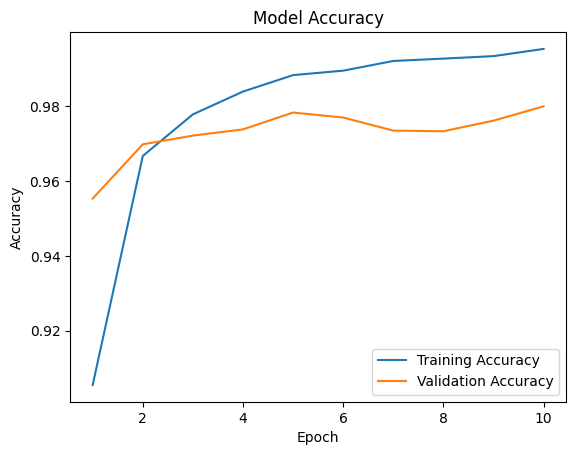

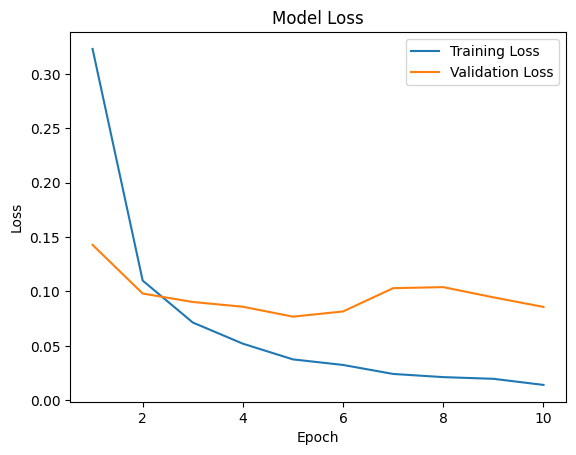

In [20]:
'''
Fully connected Neural Network
'''

# Define the model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

DNN_model = MNISTModel()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
DNN_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DNN_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
DNN_train_losses = []
DNN_val_losses = []
DNN_train_accuracies = []
DNN_val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    DNN_model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = DNN_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    DNN_train_losses.append(epoch_loss)
    DNN_train_accuracies.append(epoch_acc.item())
    
    # Validation Phase
    DNN_model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            outputs = DNN_model(val_inputs)
            loss = criterion(outputs, val_labels)
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(preds == val_labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)
    DNN_val_losses.append(val_epoch_loss)
    DNN_val_accuracies.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

# Plot accuracy
plt.plot(range(1, num_epochs+1), DNN_train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), DNN_val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(range(1, num_epochs+1), DNN_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), DNN_val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch [1/10], Train Loss: 1.2937, Train Accuracy: 0.7500
Epoch [1/10], Validation Loss: 0.8538, Validation Accuracy: 0.8367
Epoch [2/10], Train Loss: 0.7379, Train Accuracy: 0.8453
Epoch [2/10], Validation Loss: 0.6451, Validation Accuracy: 0.8553
Epoch [3/10], Train Loss: 0.6035, Train Accuracy: 0.8608
Epoch [3/10], Validation Loss: 0.5603, Validation Accuracy: 0.8633
Epoch [4/10], Train Loss: 0.5385, Train Accuracy: 0.8698
Epoch [4/10], Validation Loss: 0.5131, Validation Accuracy: 0.8705
Epoch [5/10], Train Loss: 0.4989, Train Accuracy: 0.8757
Epoch [5/10], Validation Loss: 0.4821, Validation Accuracy: 0.8740
Epoch [6/10], Train Loss: 0.4717, Train Accuracy: 0.8807
Epoch [6/10], Validation Loss: 0.4598, Validation Accuracy: 0.8755
Epoch [7/10], Train Loss: 0.4515, Train Accuracy: 0.8839
Epoch [7/10], Validation Loss: 0.4431, Validation Accuracy: 0.8782
Epoch [8/10], Train Loss: 0.4359, Train Accuracy: 0.8867
Epoch [8/10], Validation Loss: 0.4293, Validation Accuracy: 0.8807
Epoch [9

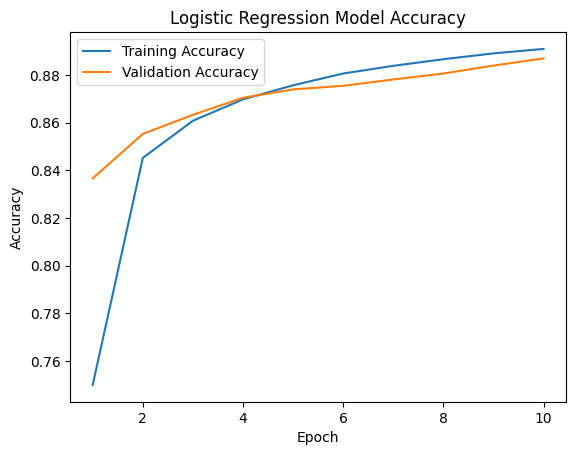

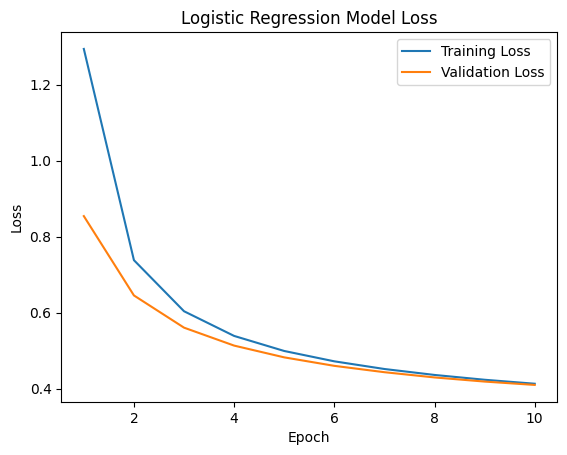

In [18]:
'''
Logistic Regression
'''

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt  # Added import for plotting

# Define Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

input_dim = 28 * 28
output_dim = 10  # Number of classes (digits 0-9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

Logistic_model = LogisticRegressionModel(input_dim, output_dim).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Logistic_model.parameters(), lr=0.01)

lg_train_losses = []
lg_val_losses = []
lg_train_accuracies = []
lg_val_accuracies = []

# Training the Logistic Regression Model
for epoch in range(num_epochs):
    # Training Phase
    Logistic_model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, 28*28).to(device)  # Flatten the input
        labels = labels.to(device)

        optimizer.zero_grad()       # Zero the gradients
        outputs = Logistic_model(inputs)     # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()             # Backpropagate the loss
        optimizer.step()            # Update weights

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)  # Get the index of the highest value (predicted class)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    lg_train_losses.append(epoch_loss)
    lg_train_accuracies.append(epoch_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')

    # Validation Phase
    Logistic_model.eval()
    val_running_loss = 0.0  # Reset validation loss
    val_running_corrects = 0  # Reset validation corrects

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.view(-1, 28*28).to(device)
            val_labels = val_labels.to(device)

            outputs = Logistic_model(val_inputs)
            loss = criterion(outputs, val_labels)

            # Track validation loss and accuracy
            val_running_loss += loss.item() * val_inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == val_labels.data)

    # Calculate average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)

    lg_val_losses.append(val_epoch_loss)  # Store validation loss
    lg_val_accuracies.append(val_epoch_acc.item())  # Store validation accuracy

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')

# Plot accuracy
plt.plot(range(1, num_epochs+1), lg_train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), lg_val_accuracies, label='Validation Accuracy')
plt.title('Logistic Regression Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(range(1, num_epochs+1), lg_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), lg_val_losses, label='Validation Loss')
plt.title('Logistic Regression Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch [1/10], Train Loss: 0.2580, Train Accuracy: 0.9221
Epoch [1/10], Validation Loss: 0.0773, Validation Accuracy: 0.9768
Epoch [2/10], Train Loss: 0.0622, Train Accuracy: 0.9806
Epoch [2/10], Validation Loss: 0.0581, Validation Accuracy: 0.9810
Epoch [3/10], Train Loss: 0.0446, Train Accuracy: 0.9859
Epoch [3/10], Validation Loss: 0.0436, Validation Accuracy: 0.9875
Epoch [4/10], Train Loss: 0.0332, Train Accuracy: 0.9898
Epoch [4/10], Validation Loss: 0.0441, Validation Accuracy: 0.9867
Epoch [5/10], Train Loss: 0.0265, Train Accuracy: 0.9919
Epoch [5/10], Validation Loss: 0.0383, Validation Accuracy: 0.9885
Epoch [6/10], Train Loss: 0.0210, Train Accuracy: 0.9935
Epoch [6/10], Validation Loss: 0.0343, Validation Accuracy: 0.9895
Epoch [7/10], Train Loss: 0.0167, Train Accuracy: 0.9949
Epoch [7/10], Validation Loss: 0.0376, Validation Accuracy: 0.9895
Epoch [8/10], Train Loss: 0.0135, Train Accuracy: 0.9959
Epoch [8/10], Validation Loss: 0.0366, Validation Accuracy: 0.9890
Epoch [9

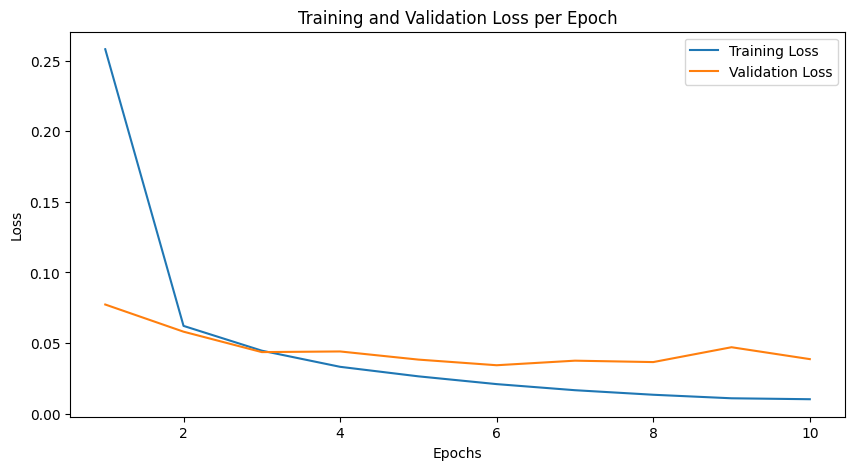

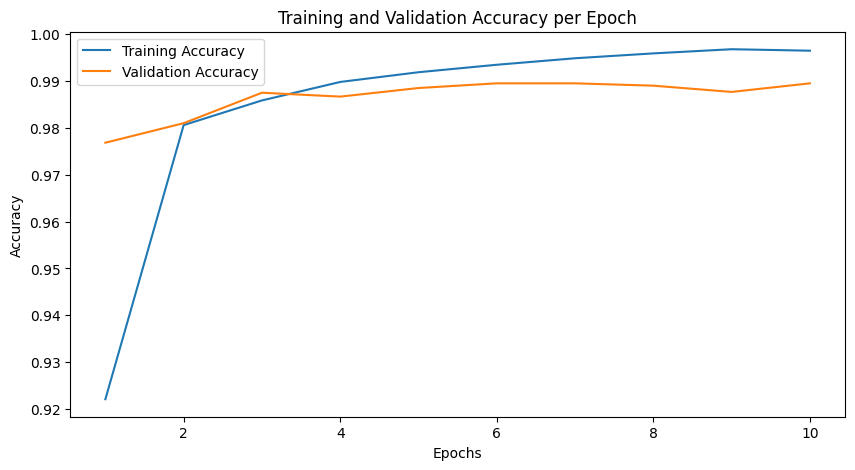

In [22]:
'''CNN Model'''

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define CNN Model for MNIST Dataset
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input size of 28x28, after pooling it becomes 7x7
        self.fc2 = nn.Linear(128, 10)  # 10 classes (digits 0-9)

    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # Flatten the tensor before fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN Model
model = CNNModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
CNN_train_losses = []
CNN_val_losses = []
CNN_train_accuracies = []
CNN_val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        # Reshape inputs to (batch_size, channels, height, width)
        inputs = inputs.view(-1, 1, 28, 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update weights

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)  # Get the index of the highest value (predicted class)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    CNN_train_losses.append(epoch_loss)
    CNN_train_accuracies.append(epoch_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.view(-1, 1, 28, 28).to(device)
            val_labels = val_labels.to(device)

            outputs = model(val_inputs)
            loss = criterion(outputs, val_labels)

            # Track validation loss and accuracy
            val_running_loss += loss.item() * val_inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == val_labels.data)

    # Calculate average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
    CNN_val_losses.append(val_epoch_loss)
    CNN_val_accuracies.append(val_epoch_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), CNN_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), CNN_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), CNN_train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), CNN_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

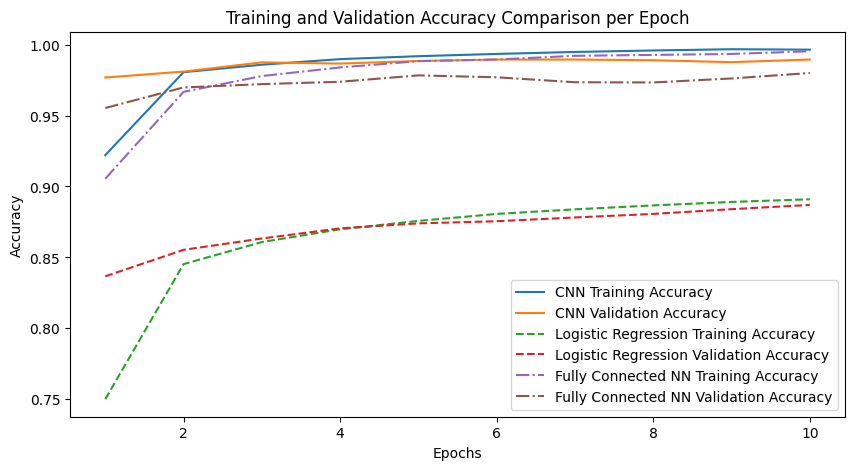

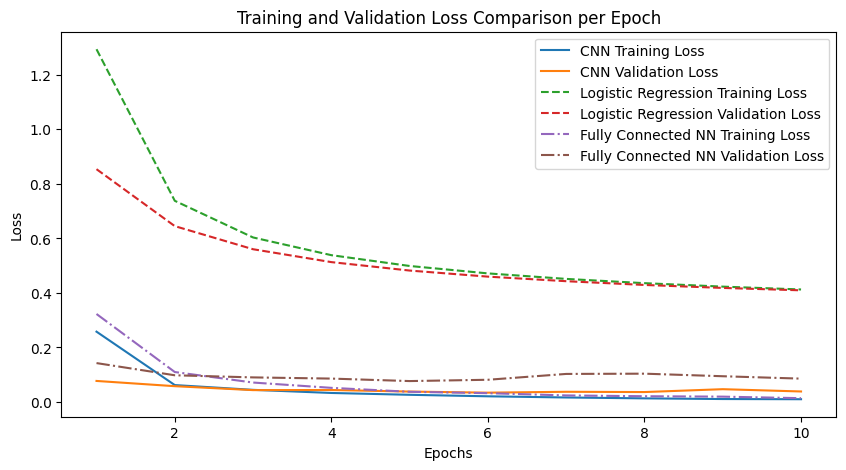

In [23]:
# Plot Comparison of CNN, Logistic Regression, and Fully Connected NN Performance
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), CNN_train_accuracies, label='CNN Training Accuracy')
plt.plot(range(1, num_epochs + 1), CNN_val_accuracies, label='CNN Validation Accuracy')
plt.plot(range(1, num_epochs + 1), lg_train_accuracies, label='Logistic Regression Training Accuracy', linestyle='--')
plt.plot(range(1, num_epochs + 1), lg_val_accuracies, label='Logistic Regression Validation Accuracy', linestyle='--')
plt.plot(range(1, num_epochs + 1), DNN_train_accuracies, label='Fully Connected NN Training Accuracy', linestyle='-.')
plt.plot(range(1, num_epochs + 1), DNN_val_accuracies, label='Fully Connected NN Validation Accuracy', linestyle='-.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), CNN_train_losses, label='CNN Training Loss')
plt.plot(range(1, num_epochs + 1), CNN_val_losses, label='CNN Validation Loss')
plt.plot(range(1, num_epochs + 1), lg_train_losses, label='Logistic Regression Training Loss', linestyle='--')
plt.plot(range(1, num_epochs + 1), lg_val_losses, label='Logistic Regression Validation Loss', linestyle='--')
plt.plot(range(1, num_epochs + 1), DNN_train_losses, label='Fully Connected NN Training Loss', linestyle='-.')
plt.plot(range(1, num_epochs + 1), DNN_val_losses, label='Fully Connected NN Validation Loss', linestyle='-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison per Epoch')
plt.legend()
plt.show()

In [17]:
'''
Test Performance
'''

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

model = DNN_model
''' 
Pad the real test data with 0 if there are columns missing and then evaluate the model
'''
# Load the test data without header
test_data = pd.read_csv('Project_Data_EE4C12_CE_IMG.csv', header=None)

# Manually set column names
column_names = ['label'] + [f'pixel_{i}' for i in range(784)]
test_data.columns = column_names

# Verify the structure of test_data
#print(test_data.head())

# Check for non-numeric values
if test_data.isnull().values.any():
    print("NaN values found in the data. Filling with 0.")
    test_data = test_data.fillna(256) # white pixels

# # Ensure all data is numeric
# test_data = test_data.apply(pd.to_numeric, errors='coerce')
# if test_data.isnull().values.any():
#     print("Non-numeric values found in the data after conversion. Filling with 0.")
#     test_data = test_data.fillna(0)

# Separate features and labels
y_test = test_data['label'].values
X_test = test_data.drop('label', axis=1).values.astype(np.float32) / 255.0

# Convert to torch tensors
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

# Verify shapes and data types
print('X_test shape:', X_test.shape)  # Should be (num_samples, 784)
print('y_test shape:', y_test.shape)  # Should be (num_samples,)
print('X_test dtype:', X_test.dtype)  # Should be torch.float32
print('y_test dtype:', y_test.dtype)  # Should be torch.int64 (long)

# Check for NaN values
print('Any NaN in X_test:', torch.isnan(X_test).any())
print('Any NaN in y_test:', torch.isnan(y_test).any())

# Proceed only if no NaN values are present
if torch.isnan(X_test).any() or torch.isnan(y_test).any():
    print("Data contains NaN values after processing. Exiting.")
    exit()

# Create dataset and dataloader
test_dataset = MNISTDataset(X_test, y_test)
batch_size = 128
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
model.eval()

test_running_loss = 0.0
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        # Since we have ensured no NaNs, we can proceed safely
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels.data)

test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects.double() / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Save the model
torch.save(model.state_dict(), 'mnist_dnn_model.pth')


NaN values found in the data. Filling with 0.
X_test shape: torch.Size([8043, 784])
y_test shape: torch.Size([8043])
X_test dtype: torch.float32
y_test dtype: torch.int64
Any NaN in X_test: tensor(False)
Any NaN in y_test: tensor(False)
Test Loss: 0.0955
Test Accuracy: 0.9763
